# Loss and RMSE


In [60]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import multiprocessing
from tqdm import tqdm
import pickle
import pandas as pd

In [61]:
# Path to the data
cd /var/autofs/misc/home/danielr/Downloads/AppliedMachineLearning/ml-25m/results

/var/autofs/misc/home/danielr/Downloads/AppliedMachineLearning/ml-25m/results


In [62]:
# load the data_by_user 
with open(f'data_by_user_train.pickle', 'rb') as handle:
    train_data_by_user = pickle.load(handle)
    
# load the data_by_user 
with open(f'data_by_movie_train.pickle', 'rb') as handle:
    train_data_by_movie = pickle.load(handle)
    
# load the data_by_user 
with open(f'data_by_user_test.pickle', 'rb') as handle:
    test_data_by_user = pickle.load(handle)
    
# load the data_by_user 
with open(f'data_by_movie_test.pickle', 'rb') as handle:
    test_data_by_movie = pickle.load(handle)

# load the map_index_to_user
with open(f'map_index_to_user.pickle', 'rb') as handle:
    map_index_to_user = pickle.load(handle)
    
# load the map_index_to_user
with open(f'map_user_to_index.pickle', 'rb') as handle:
    map_user_to_index = pickle.load(handle)
    
# load the map_index_to_user
with open(f'map_movie_to_index.pickle', 'rb') as handle:
    map_movie_to_index = pickle.load(handle)

# load the map_index_to_user
with open(f'map_index_to_movie.pickle', 'rb') as handle:
    map_index_to_movie = pickle.load(handle)
# # load the map_index_to_user
# with open(f'movies_to_plot.pickle', 'rb') as handle:
#     movies_to_plot = pickle.load(handle)
    
# # load the map_index_to_user
# with open(f'map_id_movies.pickle', 'rb') as handle:
#     map_id_movies = pickle.load(handle)

In [63]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class CollaborativeFilteringModel:

    def __init__(self, lambda_=0.001, gamma=0.5, tau=0.01, latent_factor_dimension=5):
        """
        Initialize the Collaborative Filtering Model.

        Args:
            lambda_ (float): Regularization parameter.
            gamma (float): Regularization parameter.
            tau (float): Regularization parameter.
            latent_factor_dimension (int): Number of latent factors.
        """
        self.lambda_ = lambda_
        self.gamma = gamma
        self.tau = tau
        self.latent_factor_dimension = latent_factor_dimension
        self.sigma = np.sqrt(1 / self.latent_factor_dimension)
        self.mu = 0

        self.number_of_users = 0
        self.number_of_movies = 0

        self.user_matrix = None
        self.movie_matrix = None
        self.user_bias = None
        self.movie_bias = None
        

    def get_sparse(self, data, number_batches=4):
        '''get sparse train and test data'''
        # Shuffle the data
        data_copy = data.copy()
        np.random.shuffle(data_copy)
        data_batches = []

        batch_size = len(data) // number_batches

        # Initialize all the data structures
        # mapping from user to index
        map_user_to_index = {}
        map_index_to_user = []

        # mapping from movie to index
        map_movie_to_index = {}
        map_index_to_movie = []

        # First build the mappings.
        for user, movie, _ in tqdm(data_copy, desc="Building Mappings"):
            # Take care of the user data structure
            if user not in map_user_to_index:
                map_user_to_index[user] = len(map_index_to_user)
                map_index_to_user.append(user)

            # Take care of the movie data structure
            if movie not in map_movie_to_index:
                map_movie_to_index[movie] = len(map_index_to_movie)
                map_index_to_movie.append(movie)

        data_by_user = [[] for i in range(len(map_index_to_user))]
        data_by_movie = [[] for i in range(len(map_index_to_movie))]

        # Create all the data structure using a loop
        batch_index = 0
        for index, (user, movie, rating) in enumerate(tqdm(data, desc="Processing Data")):
            last_batch_index = batch_index
            user_id = map_user_to_index[user]
            movie_id = map_movie_to_index[movie]
            batch_index = index // batch_size
            if batch_index != last_batch_index:
                data_batches.append((data_by_user, data_by_movie))
                data_by_user = [[] for i in range(len(map_index_to_user))]
                data_by_movie = [[] for i in range(len(map_index_to_movie))]

            data_by_user[user_id].append((movie_id, float(rating)))
            data_by_movie[movie_id].append((user_id, float(rating)))

        data_batches.append((data_by_user, data_by_movie))
        return data_batches

    def update_bias(self, data_by_user, data_by_movie):
        """
        Update user and movie biases.

        Args:
            data_by_user (list of lists): User ratings data.
            data_by_movie (list of lists): Movie ratings data.
        """
        ### for user_id, update bias vector
        for user_id in range(self.number_of_users):
            bias = 0
            for movie_id, rating in data_by_user[user_id]:
                bias += self.lambda_ * (rating - (np.matmul(self.user_matrix[user_id].T, self.movie_matrix[movie_id]) + self.movie_bias[movie_id]))
            bias = bias / (self.lambda_ * len(data_by_user[user_id]) + self.gamma)
            self.user_bias[user_id] = bias

        ### for movie_id, update movie vector
        for movie_id in range(self.number_of_movies):
            bias = 0
            for user_id, rating in data_by_movie[movie_id]:
                bias += self.lambda_ * (rating - (np.matmul(self.movie_matrix[movie_id].T, self.user_matrix[user_id]) + self.user_bias[user_id]))
            bias = bias / (self.lambda_ * len(data_by_movie[movie_id]) + self.gamma)
            self.movie_bias[movie_id] = bias

    def update_matrices(self, data_by_user, data_by_movie):
        """
        Update user and movie matrices.

        Args:
            data_by_user (list of lists): User ratings data.
            data_by_movie (list of lists): Movie ratings data.

        """
        ### for each user, update user_id matrix
        for user_id in range(self.number_of_users):
            if not data_by_user[user_id]:
                continue

            right_summation = 0
            left_summation = 0
            for movie_id, rating in data_by_user[user_id]:
                left_summation += self.lambda_ * np.outer(self.movie_matrix[movie_id], self.movie_matrix[movie_id])
                right_summation += self.lambda_ * self.movie_matrix[movie_id] * (rating - self.user_bias[user_id] - self.movie_bias[movie_id])

            left_summation += self.tau * np.eye(self.latent_factor_dimension)
            left_term = np.linalg.inv(left_summation)
            self.user_matrix[user_id] = np.matmul(left_term, right_summation)

        ### for each movie, update movie_id matrix
        for movie_id in range(self.number_of_movies):
            if not data_by_movie[movie_id]:
                continue

            right_summation = 0
            left_summation = 0
            for user_id, rating in data_by_movie[movie_id]:
                left_summation += self.lambda_ * np.outer(self.user_matrix[user_id], self.user_matrix[user_id])
                right_summation += self.lambda_ * self.user_matrix[user_id] * (rating - self.movie_bias[movie_id] - self.user_bias[user_id])

            left_summation += self.tau * np.eye(self.latent_factor_dimension)
            left_term = np.linalg.inv(left_summation)
            self.movie_matrix[movie_id] = np.matmul(left_term, right_summation)

    def calculate_loss(self, sparse_user_ratings, sparse_movie_ratings):
        """
        Calculate the loss of the collaborative filtering model with regularization.

        Args:
            sparse_user_ratings (list of lists): User ratings data.
            sparse_movie_ratings (list of lists): Movie ratings data.

        Returns:
            float: The calculated loss value.
        """
        # Initialisation
        summation, numn_rating, user_matrix_reg_term, movie_matrix_reg_term = 0, 0, 0, 0

        # Loss 
        for user_id in range(self.number_of_users):
            for movie_id, rating in sparse_user_ratings[user_id]:
                predicted_rating = self.predict(user_id, movie_id)
                prediction_error = rating - predicted_rating
                summation += prediction_error**2

        #  Regularization terms
        user_bias_reg_term = self.gamma * np.sum(self.user_bias**2)
        movie_bias_reg_term = self.gamma * np.sum(self.movie_bias**2)

        # compute user matrix and movie matrix regularization term
        for user_id in range(self.number_of_users):
            user_matrix_reg_term += np.matmul(self.user_matrix[user_id], self.user_matrix[user_id])
        user_matrix_reg_term *= self.tau 
        for movie_id in range(self.number_of_movies):
            movie_matrix_reg_term += np.matmul(self.movie_matrix[movie_id], self.movie_matrix[movie_id])
        movie_matrix_reg_term *= self.tau 

        loss = 0.5 * (- summation * self.lambda_ - (user_bias_reg_term + movie_bias_reg_term + user_matrix_reg_term + movie_matrix_reg_term)) 
        return loss
            
    def calculate_rmse(self, sparse_user_ratings):
        """
        Calculate the Root Mean Square Error (RMSE) of the model.

        Args:
            sparse_user_ratings (list of lists): User ratings data.

        Returns:
            float: The calculated RMSE.
        """
        
        error, num_rating = 0, 0

        for user_id in range(self.number_of_users):
            for movie_id, rating in sparse_user_ratings[user_id]:
                prediction = self.predict(user_id, movie_id)
                error += (rating - prediction) ** 2
                num_rating += 1

        return np.sqrt(error / num_rating)
       
    def train_model(self, train_data_by_user, train_data_by_movie, test_data_by_user, test_data_by_movie,
                number_iterations=10, folder_parameters=None, bias_only = False):
        """
        Train the collaborative filtering model.

        Args:
            train_data_by_user (list of lists): Training user ratings data.
            train_data_by_movie (list of lists): Training movie ratings data.
            test_data_by_user (list of lists): Test user ratings data.
            test_data_by_movie (list of lists): Test movie ratings data.
            number_of_iterations (int): Number of training iterations.
            folder_parameters (str): Folder path to load existing parameters.
        """
        self.number_of_iterations = number_iterations
        self.number_of_users = len(train_data_by_user)
        self.number_of_movies = len(train_data_by_movie)

        if folder_parameters is None:
            # Initialize model parameters if not loading existing parameters
            self.user_matrix = np.random.normal(0, self.sigma, size=(self.number_of_users, self.latent_factor_dimension))
            self.movie_matrix = np.random.normal(0, self.sigma, size=(self.number_of_movies, self.latent_factor_dimension))
            self.user_bias = np.zeros(self.number_of_users)
            self.movie_bias = np.zeros(self.number_of_movies)
            
            self.loss_train, self.rmse_train, self.loss_test, self.rmse_test = [], [], [], []
        else:
            # Load existing parameters from the specified folder
            self.load_parameters(folder_parameters)


        length_train = len(self.loss_train)

        for i in range(length_train, self.number_of_iterations + length_train):
            self.update_bias(train_data_by_user, train_data_by_movie)
            if not bias_only: self.update_matrices(train_data_by_user, train_data_by_movie)
            self.loss_train.append(self.calculate_loss(train_data_by_user, train_data_by_movie))
            self.rmse_train.append(self.calculate_rmse(train_data_by_user))
            self.loss_test.append(self.calculate_loss(test_data_by_user, test_data_by_movie))
            self.rmse_test.append(self.calculate_rmse(test_data_by_user))
            print(f'iteration: {i}, loss_train: {self.loss_train[i]}, rmse_train: {self.rmse_train[i]}, '
                  f'loss_test: {self.loss_test[i]}, rmse_test: {self.rmse_test[i]}')


    


        
    def save_parameters(self, folder_path):
        import joblib
        parameters = {
            'user_matrix': self.user_matrix,
            'movie_matrix': self.movie_matrix,
            'user_bias': self.user_bias,
            'movie_bias': self.movie_bias,
            'loss_train' : self.loss_train,
            'rmse_train' : self.rmse_train,
            'loss_test': self.loss_test,
            'rmse_test': self.rmse_test
        }

        joblib.dump(parameters, folder_path)


    def load_parameters(self, folder_path):
        import joblib
        parameters = joblib.load(folder_path)
        self.user_matrix = parameters['user_matrix']
        self.movie_matrix = parameters['movie_matrix']
        self.user_bias = parameters['user_bias']
        self.movie_bias = parameters['movie_bias']
        self.loss_train = parameters['loss_train']
        self.rmse_train = parameters['rmse_train']
        self.loss_test = parameters['loss_test']
        self.rmse_test = parameters['rmse_test']

    
    def predict(self, user_id, movie_id):
        return np.dot(self.user_matrix[user_id].T, self.movie_matrix[movie_id]) + self.user_bias[user_id] + self.movie_bias[movie_id]
    
    def plot_loss_rmse(self, savefig = False):
        """
        Plot the loss and RMSE curves.

        Args:
            savefig (bool, optional): Whether to save the figure as a PDF.
        """
        if len(self.loss_train) == 0:
            print('The model must be trained first')
        else:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
            ax = ax.flatten()

            # Plot the RMSE
            sns.lineplot(x=range(len(self.loss_train)), y=self.rmse_train, label='train rmse', ax=ax[0])
            sns.lineplot(x=range(len(self.loss_train)), y=self.rmse_test, label='test rmse', ax=ax[0]).set(title=f'RMSE, K = {self.latent_factor_dimension}')
            ax[0].set_xlabel("Iterations")
            ax[0].set_ylabel("Root Mean Square Error (RMSE)")


            # Plot the loss
            sns.lineplot(x=range(len(self.loss_train)), y=self.loss_train, label='train loss', ax=ax[1])
            sns.lineplot(x=range(len(self.loss_train)), y=self.loss_test, label='test loss', ax=ax[1]).set(title=f'loss function, K = {self.latent_factor_dimension}')
            ax[1].set_xlabel("Iterations")
            ax[1].set_ylabel("Loss")

            if savefig:
                plt.savefig(savefig)
            plt.tight_layout()
            plt.show()
            
    
    

In [64]:
model = CollaborativeFilteringModel(lambda_=0.001, gamma=0.5, tau=0.01, latent_factor_dimension = 10)

In [65]:
model.train_model(train_data_by_user, train_data_by_movie, test_data_by_user, test_data_by_movie, 0, 'weights.pkl')

In [66]:
model.rmse_train

[1.1363739789421612,
 0.850361010476377,
 0.7807066471445453,
 0.7607998903163016,
 0.7526636581772512,
 0.7489095985689241,
 0.7468783942915308,
 0.7456438682856147,
 0.7448395912380108,
 0.7442921205921545,
 0.7439064195903617]

In [67]:
model.rmse_test

[1.212782289366876,
 0.8994591156486266,
 0.8333603527418347,
 0.8156764515766296,
 0.808945817881278,
 0.8061019122775483,
 0.8046550667084221,
 0.8037938654099582,
 0.8032194388177538,
 0.8028005751896499,
 0.8024700255242928]

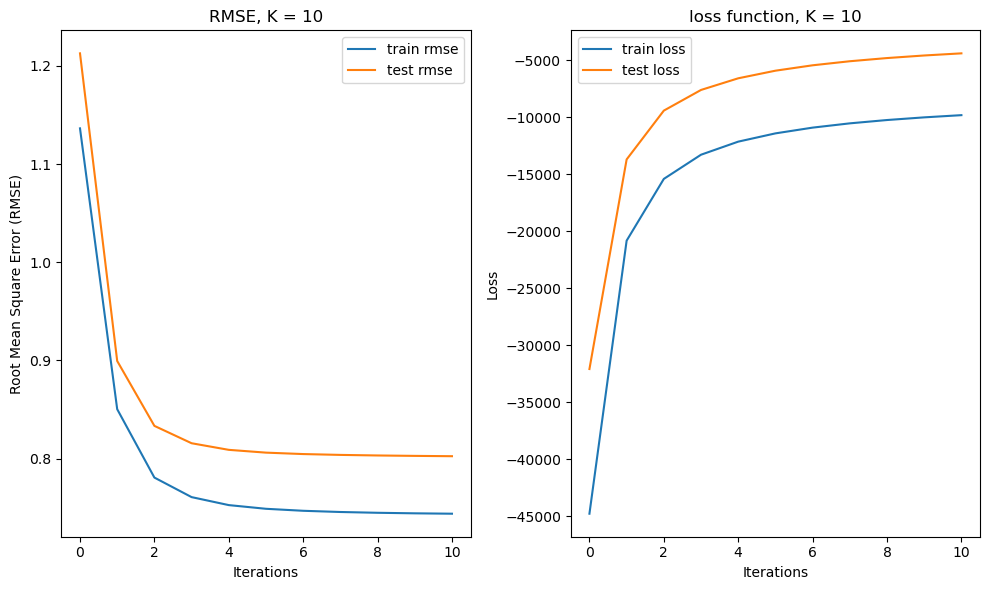

In [68]:
model.plot_loss_rmse(savefig = 'updates_matrices_latent_10.pdf')

In [69]:
# model.save_parameters('weights.pkl')

In [70]:
#model.load_parameters('weights_bias_only.pkl')

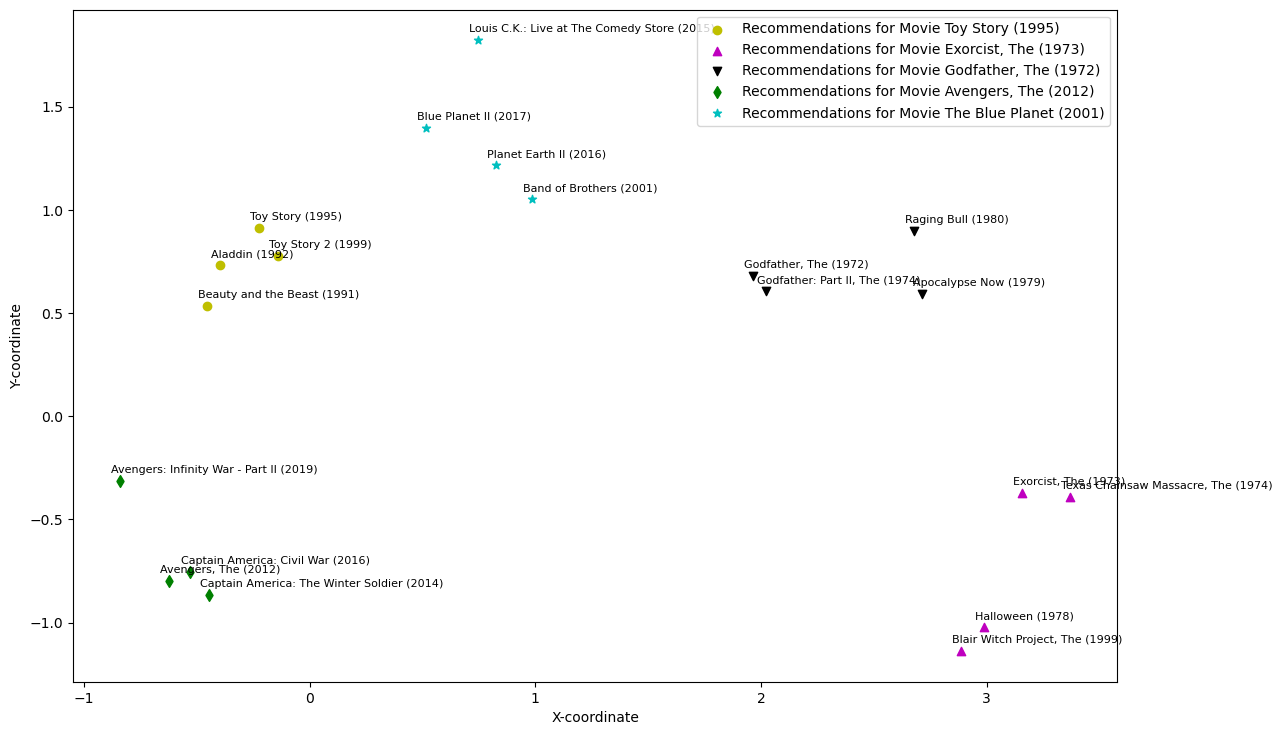

In [71]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import random
path_movie = '/var/autofs/misc/home/danielr/Downloads/AppliedMachineLearning/ml-25m/movies.csv'
# Read movie data into a dictionary
def read_movie_data(file_path):
    dict_movies = {}
    with open(file_path, 'r') as data_file:
        data_reader = csv.reader(data_file)
        next(data_reader)  
        dict_movies = {int(row[0]): row[1] for row in data_reader}
    return dict_movies

def search(movie_title, path_movie):
    dict_movies = read_movie_data(path_movie)
    
    # Find movies that match the keywords in the title
    keyword_matches = [(movie_id, title) for movie_id, title in dict_movies.items() if movie_title.lower() in title.lower()]
    
    if not keyword_matches:
        print(f"No movies found with keywords in the title: {movie_title}")
        return []
    return keyword_matches

def get_recommendations(movie_system_id, model):
    movie_matrix = model.movie_matrix
    movie_id = map_movie_to_index[movie_system_id]
    similarity_scores = np.dot(movie_matrix, movie_matrix[movie_id])
    top_indices = np.argsort(similarity_scores)[-4:]
    return top_indices

def plot_recommendations(movie_ids, model, title, name = None):
    plt.figure(figsize=(12, 8))
    dict_movies = read_movie_data(path_movie)
    
    # list of colors and markers
    colors = ['b', 'g', 'r', 'y', 'c', 'm', 'k']
    markers = ['o', '^', 's', 'd', 'v', 'p', '*']
    
    # Determine the number of unique colors and markers needed based on the input length
    num_colors = min(len(movie_ids), len(colors))
    num_markers = min(len(movie_ids), len(markers))
    
    random.shuffle(colors)  # Shuffle the colors for variety
    random.shuffle(markers)  # Shuffle the markers for variety
    
    for i, movie_id in enumerate(movie_ids):
        x1, x2 = (0, 1) if model.movie_matrix.shape[1] == 2 else (7, 3)
        top_recommendations = get_recommendations(movie_id, model)
        coordinates = model.movie_matrix[top_recommendations][:, [x1, x2]]
        
        # Select a color and marker based on the current index
        color = colors[i % num_colors]
        marker = markers[i % num_markers]
        
        plt.scatter(coordinates[:, 0], coordinates[:, 1], marker=marker, c=color, label=f"Recommendations for Movie {dict_movies[movie_id]}")
        
        text_offset = 0.04
        for j, movie_idx in enumerate(top_recommendations):
            plt.annotate(dict_movies[map_index_to_movie[movie_idx]], (coordinates[j, 0] - text_offset, coordinates[j, 1] + text_offset), fontsize=8)
    
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.title(title)
    plt.legend()
    plt.grid(False)
    
    plt.subplots_adjust(left=0.08, right=0.95, top=0.92, bottom=0.08)
    if name:
        plt.savefig(name, format="pdf")
    plt.show()

    
movie_ids_and_colors = [1, 1997, 858, 89745, 142115]

plot_recommendations(movie_ids_and_colors, model, title='') 


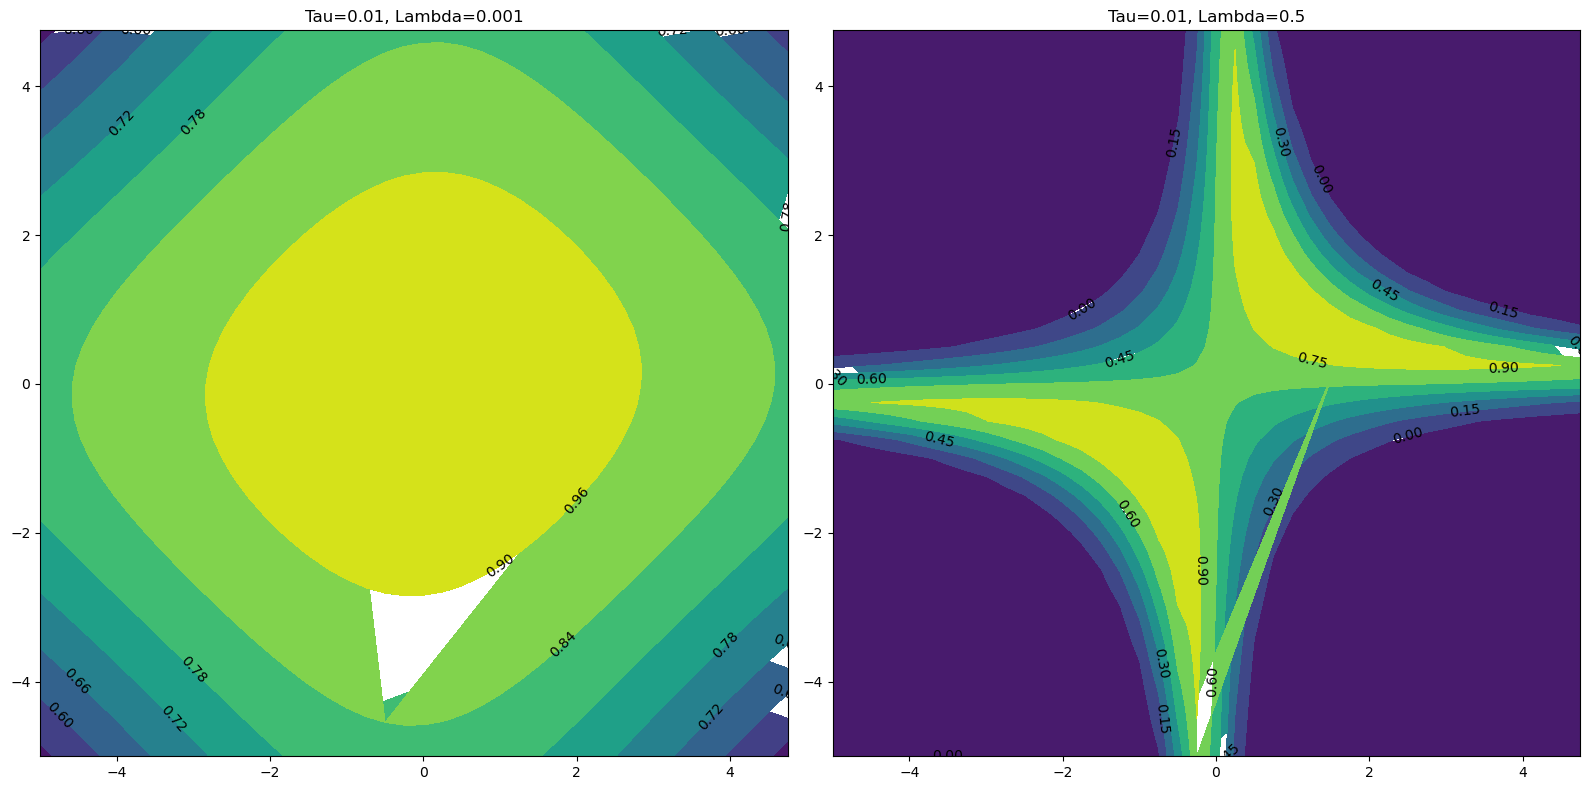

In [72]:
def plot_contour(tau_values, lambd_values, r):
    X = np.arange(-5, 5, 0.25)
    Y = np.arange(-5, 5, 0.25)
    X, Y = np.meshgrid(X, Y)
    
    plt.figure(figsize=(16, 8))
    
    for tau in tau_values:
        for lambd in lambd_values:
            Pu = np.exp(-0.5 * tau * X**2)
            Pv = np.exp(-0.5 * tau * Y**2)
            Puv = np.exp(-0.5 * lambd * (r - X * Y) ** 2)

            Z = Pu * Pv * Puv
            
            plt.subplot(len(tau_values), len(lambd_values), tau_values.index(tau) * len(lambd_values) + lambd_values.index(lambd) + 1)
            
            contour = plt.contourf(X, Y, Z)
            
            plt.clabel(contour, inline=True, fontsize=10, colors='black')
            plt.title(f"Tau={tau}, Lambda={lambd}")
    plt.savefig("hyperparameters.pdf", format="pdf")
    plt.tight_layout()
    plt.show()

tau_values = [0.01]
lambd_values = [0.001, 0.5]
r = 1

plot_contour(tau_values, lambd_values, r)
